### ***Theory of random forest***

As described in DT notebook, DT can be subject to high overfitting because they have low bias and high variance errors. The first is high if we have made a lot of assumptions abpout the target function, so if our modelling function is not flexible. The second, instead, refers to the variability of a target function w.r.t. different training samples: models with high varianvce will change a lot when small modifications of the training dataset are made. The idea used by RF to overcome this limitations is to build multiple trees and average their prediction for regression or use majority voting for classification. Each tree is built using a different dataset and a random subset of features.

To reduce the variance error, RF employs *bootstrap aggregation* (or *bagging*). Among the different techniques used for it, the one that will be used in this notebook was proposed by the inventors of RF Leo Breiman and Adele Cutler. Given a dataset $D=\{(X_1, y_1), \dots, (X_N, y_N)\}$ where $X_i$ are the features and $y_i$ the labels, we generate $B$ bootstraped samples $D_1, \dots, D_B$ by sampling with replacement $N$ tuples from $D$. Because replacement is allowed there might be some duplicate elements in $D_k$. Then, a decision tree $T_i$ is trained using $D_i$. Without bootrapping, all the trees would be highly correlated, i.e. if $T_i$ predicts label $\tilde y$, there's a high chance that also $T_k$ will predict $\tilde y$: consequently, if one overfits, also the other will overfit either. Note that this allows us to parallelize the training process: different machines will train one (or several) model.

Moreover, each $T_i$ is built considering only a random subset of $|F_i|=m$ features among the total $|F|=d$ features at eah best split call (see `DecisionTree.find_best_split(...)`): if we used the entire features vector, even with bootstrapping, there would be an high chance to keep using the mostly dominant features, not reducing correlation. Typically, $m=\sqrt{d}$ for classification and $m=\frac13d$ for regression. 

When it comes to make a prediction for a classification task, the idea is to use *majority voting*:
$$\tilde y = \argmax_{k}\,\,\sum_{i = 1}^{B}\mathbb{I}\{T_i(x) = k\}$$

where $k$ is a label, $\mathbb{I}\{...\}$ is the indicator function and $T_i(x)$ is the prediction of the $i\text{-th}$ tree.

Viceversa, for a regrassion task (not necessary in this notebook, but reported for the sake of completeness):
$$\tilde y = \frac1B\sum_{i=1}^{B}T_i(x)$$

### ***Model definition***

In [1]:
import numpy as np
from tqdm import tqdm
import scipy

import sys
sys.path.append("..")
from utils.models.DecisionTree import DecisionTree

In [2]:
class RandomForest:
    def __init__(self, 
                 n_trees = 10,
                 criterion = "gini", 
                 max_depth = None, 
                 min_samples_split = 2, 
                 min_samples_leaf = 1, 
                 min_impurity_decrease = 0.0,
                 max_thresholds = 1,
                 random_state = 0):
        
        """
            Initialize the decision tree parameters.
            
            Args:
                - Parameters of RF:
                    n_trees (int): number of trees to be built
                    random_state (int): random seed.
                
                - Paramters of DT to be built: 
                    criterion (str): the function to measure the quality of a split ("gini" or "entropy").
                    max_depth (int): the maximum depth of the tree.
                    min_samples_split (int): the minimum number of samples required to split an internal node.
                    min_samples_leaf (int): the minimum number of samples required to be at a leaf node.
                    min_impurity_decrease (float): the minimum impurity decrease required to split a node.
                    max_thresholds (int): the maximum number of thresholds to use during best split search.
                    max_features (str / float): the maximum number of features to choose from in the given ones: 
                                                    - if "sqrt", then int(sqrt(n_features)); 
                                                    - if "log2", then int(log2(n_features)):
                                                    - if float, then int(n_features * max_features);
                                                    - if None, all features
                    random_state (int): random seed.
        """
        
        self.n_trees = n_trees

        #When the traing process is complete, all the DecisionTree objects in this list will be trained
        self.trees = [DecisionTree(criterion = criterion,
                                   max_depth = max_depth,
                                   min_samples_split = min_samples_split,
                                   min_samples_leaf = min_samples_leaf,
                                   min_impurity_decrease = min_impurity_decrease,
                                   max_thresholds = max_thresholds,
                                   max_features = "sqrt", #As explained in the theory part, for classification tasks, sqrt(n_features) have to be used.
                                                          #Thus, we pass directly to the DT the parameter max_features = "sqrt", so that it will be the DT to selct randomly them;
                                                          #see for more details methods "build_tree(...)" and "find_best_split(...)" of DT.
                                   random_state = random_state)
                     for _ in range(self.n_trees)]

        self.random_state = random_state

    def fit(self, X, y):
        for i in tqdm(range(self.n_trees), desc = "Training of RF"):
            bs_ids = np.random.choice(np.arange(X.shape[0]), X.shape[0], replace = True)
            X_bs = X[bs_ids]
            y_bs = y[bs_ids]

            self.trees[i].fit(X_bs, y_bs)

    def predict(self, X):
        predictions = np.array([t.predict(X) for t in self.trees])  
        
        labels, counts = scipy.stats.mode(predictions, axis = 0, keepdims = False)

        scores = counts / predictions.shape[0]

        return labels, scores


### ***Usage of the model***

In [253]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import sys
sys.path.append("..")

from utils.preprocessing import undersample, fit_resample

import utils.model_evaluation as me
import matplotlib.pyplot as plt

import networkx as nx

In [295]:
#Load the dataset
init_data = pd.read_csv("../creditcard_2021.csv")
data = init_data[me.feature_vectors["v5"] + ["Class"]]

#"Class" column is the target variable, so we remove it from the feature matrix and store it in the variable y
X = data.drop(columns = ["Class"])
y = data["Class"]

X = np.array(X)
y = np.array(y)

In [296]:
#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [297]:
#Note: in constrant with what have been done for DT, here we apply SMOTE because we have observed experimentally that it increases the recall with slight decrease of the precision on the testing set
X_smote = fit_resample(X_train[y_train == 1], 2500, 10)

X_train = np.vstack((X_train, X_smote))
y_train = np.hstack((y_train, [1] * 2500))

In [298]:
rf = RandomForest(n_trees = 25,
                  criterion = "entropy", 
                  max_depth = 15, 
                  min_samples_split = 5, 
                  min_samples_leaf = 2, 
                  min_impurity_decrease = 1e-5, #Important parameter: small changes can lead to big differences in the tree and its performance
                  max_thresholds = 100, 
                  random_state = 0)

In [299]:
#Once defined, we can train the model
rf.fit(X_train, y_train)

Training of RF: 100%|██████████| 25/25 [03:50<00:00,  9.23s/it]


In [300]:
#Once trained, we can make predictions
y_pred, votes = rf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(85443,))

Precision: 0.921875
Recall: 0.8027210884353742
F1 Score: 0.8581818181818183
Accuracy: 0.9995435553526912
AUC Score: 0.9013019248217014


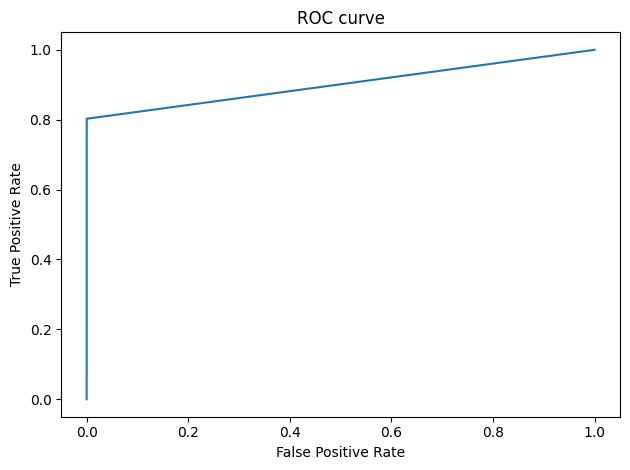

In [301]:
metrics = me.compute_metrics(y_pred, y_test)

print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1 Score:", metrics["f1"])
print("Accuracy:", metrics["accuracy"])

print("AUC Score:", metrics["auc"])

plt.plot(metrics["roc"]["fpr"], metrics["roc"]["tpr"])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.tight_layout()
plt.show()

In [329]:
#One thing that we can try to do is undersampling:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, y_train = undersample(X_train, y_train, 0, 1 - (sum(y_train) * 300.0 / X_train.shape[0]))

In [330]:
rf = RandomForest(n_trees = 20,
                  criterion = "gini", 
                  max_depth = 10, 
                  min_samples_split = 2, 
                  min_samples_leaf = 1, 
                  min_impurity_decrease = 1e-5, #Important parameter: small changes can lead to big differences in the tree and its performance
                  max_thresholds = 100, 
                  random_state = 0)

In [331]:
#Once defined, we can train the model
rf.fit(X_train, y_train)

Training of RF: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


In [332]:
#Once trained, we can make predictions
y_pred, votes = rf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(85443,))

Precision: 0.941747572815534
Recall: 0.6598639455782312
F1 Score: 0.7759999999999999
Accuracy: 0.9993445923013002
AUC Score: 0.8298968011515242


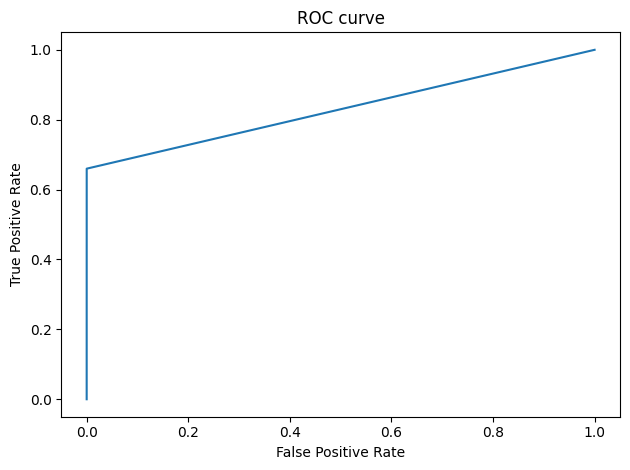

In [333]:
metrics = me.compute_metrics(y_pred, y_test)

print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1 Score:", metrics["f1"])
print("Accuracy:", metrics["accuracy"])

print("AUC Score:", metrics["auc"])

plt.plot(metrics["roc"]["fpr"], metrics["roc"]["tpr"])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.tight_layout()
plt.show()